Dropdown(description='Optimizer:', options=('SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad'), style=Descriptio…

FloatLogSlider(value=0.01, description='Learning Rate:', max=0.0, min=-5.0, style=SliderStyle(description_widt…

FloatSlider(value=0.9, description='Beta:', max=0.999, min=0.5, step=0.01, style=SliderStyle(description_width…

FloatSlider(value=0.999, description='Beta2:', max=0.999, min=0.5, step=0.001, style=SliderStyle(description_w…

IntSlider(value=1000, description='Epochs:', max=5000, min=100, step=100, style=SliderStyle(description_width=…

Button(description='Train Model', style=ButtonStyle())

Button(description='Plot Loss Surface', style=ButtonStyle())

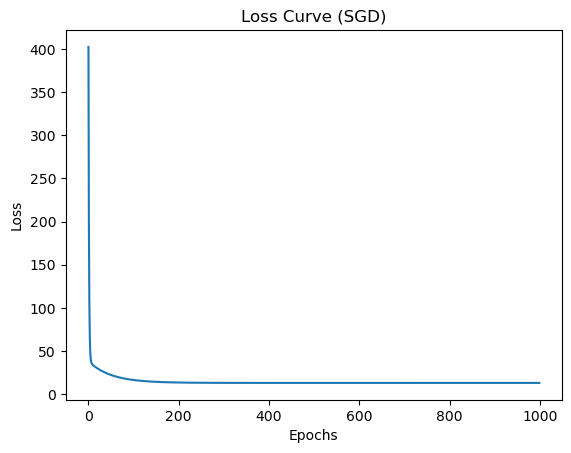

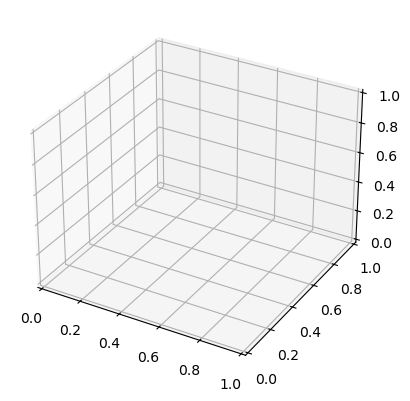

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display

class NeuralNetwork:
    def __init__(self, optimizer='SGD', lr=0.01, beta=0.9, beta2=0.999, epsilon=1e-8, epochs=1000):
        self.optimizer = optimizer
        self.lr = lr
        self.beta = beta
        self.beta2 = beta2
        self.epsilon = epsilon
        self.epochs = epochs
        self.w = np.random.randn()
        self.b = np.random.randn()
        self.history = []
        self.loss_history = []
        self.vdw, self.sdw = 0, 0
        self.vdb, self.sdb = 0, 0
        self.t = 0

    def forward(self, X):
        return self.w * X + self.b

    def compute_loss(self, Y_pred, Y):
        m = len(Y)
        return (1/(2*m)) * np.sum((Y_pred - Y) ** 2)

    def backward(self, X, Y):
        m = len(Y)
        Y_pred = self.forward(X)
        dw = (1/m) * np.sum((Y_pred - Y) * X)
        db = (1/m) * np.sum(Y_pred - Y)
        loss = self.compute_loss(Y_pred, Y)
        self.history.append((self.w, self.b, loss))
        self.loss_history.append(loss)
        self.update_parameters(dw, db)

    def update_parameters(self, dw, db):
        if self.optimizer == 'SGD':
            self.w -= self.lr * dw
            self.b -= self.lr * db
        elif self.optimizer == 'Momentum':
            self.vdw = self.beta * self.vdw + (1 - self.beta) * dw
            self.vdb = self.beta * self.vdb + (1 - self.beta) * db
            self.w -= self.lr * self.vdw
            self.b -= self.lr * self.vdb
        elif self.optimizer == 'RMSprop':
            self.sdw = self.beta * self.sdw + (1 - self.beta) * dw**2
            self.sdb = self.beta * self.sdb + (1 - self.beta) * db**2
            self.w -= self.lr * dw / (np.sqrt(self.sdw + self.epsilon))
            self.b -= self.lr * db / (np.sqrt(self.sdb + self.epsilon))
        elif self.optimizer == 'Adam':
            self.t += 1
            self.vdw = self.beta * self.vdw + (1 - self.beta) * dw
            self.vdb = self.beta * self.vdb + (1 - self.beta) * db
            self.sdw = self.beta2 * self.sdw + (1 - self.beta2) * dw**2
            self.sdb = self.beta2 * self.sdb + (1 - self.beta2) * db**2
            vdw_corrected = self.vdw / (1 - self.beta**self.t)
            vdb_corrected = self.vdb / (1 - self.beta**self.t)
            sdw_corrected = self.sdw / (1 - self.beta2**self.t)
            sdb_corrected = self.sdb / (1 - self.beta2**self.t)
            self.w -= self.lr * vdw_corrected / (np.sqrt(sdw_corrected) + self.epsilon)
            self.b -= self.lr * vdb_corrected / (np.sqrt(sdb_corrected) + self.epsilon)
        elif self.optimizer == 'Adagrad':
            self.sdw += dw**2
            self.sdb += db**2
            self.w -= self.lr * dw / (np.sqrt(self.sdw + self.epsilon))
            self.b -= self.lr * db / (np.sqrt(self.sdb + self.epsilon))

    def train(self, X, Y):
        for _ in tqdm(range(self.epochs), desc=f'Training ({self.optimizer})'):
            self.backward(X, Y)

np.random.seed(42)
X = np.linspace(-10, 10, 100)
Y = 3 * X + 7 + np.sin(X) * 5 + np.random.randn(*X.shape) * 4
X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.2, random_state=42)

def train_and_visualize(optimizer, lr, beta, beta2, epochs):
    model = NeuralNetwork(optimizer=optimizer, lr=lr, beta=beta, beta2=beta2, epochs=epochs)
    model.train(X_train, Y_train)
    plt.figure()
    plt.plot(model.loss_history)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve ({optimizer})')
    plt.show(block=False)

def plot_loss_surface():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.show(block=False)

optimizer_dropdown = widgets.Dropdown(
    options=['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad'],
    value='SGD',
    description='Optimizer:',
    style={'description_width': 'initial'}
)

lr_slider = widgets.FloatLogSlider(
    value=0.01, base=10, min=-5, max=0,
    description='Learning Rate:',
    style={'description_width': 'initial'}
)

beta_slider = widgets.FloatSlider(
    value=0.9, min=0.5, max=0.999, step=0.01,
    description='Beta:',
    style={'description_width': 'initial'}
)

beta2_slider = widgets.FloatSlider(
    value=0.999, min=0.5, max=0.999, step=0.001,
    description='Beta2:',
    style={'description_width': 'initial'}
)

epochs_slider = widgets.IntSlider(
    value=1000, min=100, max=5000, step=100,
    description='Epochs:',
    style={'description_width': 'initial'}
)

train_button = widgets.Button(description='Train Model')
plot_button = widgets.Button(description='Plot Loss Surface')

def on_train_button_clicked(_):
    train_and_visualize(
        optimizer_dropdown.value,
        lr_slider.value,
        beta_slider.value,
        beta2_slider.value,
        epochs_slider.value
    )

def on_plot_button_clicked(_):
    plot_loss_surface()

train_button.on_click(on_train_button_clicked)
plot_button.on_click(on_plot_button_clicked)
display(optimizer_dropdown, lr_slider, beta_slider, beta2_slider, epochs_slider, train_button, plot_button)